Hi, Marcel! 

Hope it'll help you to run my code quicker :)

Alex

## Input format

| ID |     Name    | FA_Name | Value |
|---:|:-----------:|:-------:|-------|
|  1 | Revenue_123 | Revenue | -100  |
where **ID** - is actual Business Processes ID, **Name** is the full name of FinancialAccount (not sure that it's required, but initially as I guess one has something like "Revenue_1", "Revenue_2" for different product and only after application of Coarse-graining financial accounts we are getting **FA_Name** value. **Value** is just a amount.
## Extraction signatures of BP
For that purpose I've implemented aggregation function over *groupby()* object, as input it uses one BP – a part of original DF with the same ID value – and return a string like
```
'([(\\'Revenue\\', 0.8336558167088283), (\\'Tax\\', 0.1663441832911717)], [(\\'TradeReceivables\\', 1.0)])'
```
then we leave only unique signatures (SAME FA from left and right part AND EXACTLY EQUAL coefficients).
## Data preprocessing
Then on that DataFrame you need to apply [*prepare_data()*](https://github.com/AlexWorldD/NetEmbs/blob/master/NetEmbs/DataProcessing/prepare_data.py) - please read the documentation to that function. The last thing I've added is 
```
 :param unique: True if Data has to be filtered wrt to Signatures of BPs
 ```

After that you should get the following structure:

| ID |     Name    | FA_Name | Value | Debit | Credit | from |
|---:|:-----------:|:-------:|-------|-------|--------|------|
|  1 | Revenue_123 | Revenue | -100  | 0.0   | 1.0    | True |

here **from** is for visualization purposes only (different colors of ingoing/outgoing edges)
## Construct FSN
Now we can construct FSN from our DataFrame, *build()* method of *FSN* class. 

I recommend to check the construction via *get_FA()* method, it should return the set of Financial Account nodes.
## RandomWalks
#### Already implemented step strategies
1. Pure RandomWalk (uniform probabilities, follows the direction)
2. MetaDef (change directions, uniform probabilities)
3. MetaDefWeighted (change directions, weighted probabilities "rich gets richer")
4. MetaDiff (change directions, probabilities depend on the differences between edges)

For test purpose you can try *randomWalk()* from NetEmbs.FSN.utils, it returns the sampled sequence. 

**BUT**, I've implemented special helper funciton for adding to original DataFrame a column with N top joint-appearance nodes. It's *add_similar()* function from NetEmbs.FSN.utils.

You also can test it with different step strategies: "DefUniform", "DefWeighted", "MetaUniform", "MetaWeighted", "MetaDiff" (version argument).

### Example with sampled data

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
plt.rcParams["figure.figsize"] = [20,10]
from NetEmbs.DataProcessing.normalize import normalize
from NetEmbs.DataProcessing.connect_db import *
from NetEmbs.GenerateData.complex_df import sales_collections
d = upload_data("Simulation/FSN_Data.db", limit=100)
d.head(5)

,ID,Name,FA_Name,Value
0,1,Revenue_1,Revenue,-487.000000
1,1,Tax_1,Tax,-102.456626
2,1,TradeReceivables_1,TradeReceivables,589.456626
3,2,CostOfSales_8,CostOfSales,487.000000
4,2,Inventory_8,Inventory,-487.000000


### Marcel, below you can test your input format, it should work correctly

Taking into account that real data already has two columns with debited and credited amounts, for preprocessing it you need to apply sequentially 

*rename_columns()*

with default arguments it's fit for your column titles and then 

*prepare_data(..., split=False)*

In [3]:
from NetEmbs.DataProcessing import *
YOUR_DATAFRAME = None
if YOUR_DATAFRAME is None:
    d = prepare_data(d)
else:
    d = prepare_data(rename_columns(YOUR_DATAFRAME), split=False)
d.head(20)

,ID,Signature,Name,FA_Name,Value,Debit,Credit,from
0,1,"([('Revenue', 0.8261846226499184), ('Tax', 0.1...",Revenue_1,Revenue,-487.000000,0.0,0.826185,True
1,1,"([('Revenue', 0.8261846226499184), ('Tax', 0.1...",Tax_1,Tax,-102.456626,0.0,0.173815,True
2,1,"([('Revenue', 0.8261846226499184), ('Tax', 0.1...",TradeReceivables_1,TradeReceivables,589.456626,1.0,0.000000,False
3,2,"([('Inventory', 1.0)], [('CostOfSales', 1.0)])",CostOfSales_8,CostOfSales,487.000000,1.0,0.000000,False
4,2,"([('Inventory', 1.0)], [('CostOfSales', 1.0)])",Inventory_8,Inventory,-487.000000,0.0,1.000000,True
5,3,"([('Revenue', 0.819660287888384), ('Tax', 0.17...",Revenue_8,Revenue,-909.000000,0.0,0.819660,True
6,3,"([('Revenue', 0.819660287888384), ('Tax', 0.17...",Tax_8,Tax,-190.890000,0.0,0.172129,True
7,3,"([('Revenue', 0.819660287888384), ('Tax', 0.17...",nsnxlg_8,nsnxlg,-1.182302,0.0,0.001066,True
8,3,"([('Revenue', 0.819660287888384), ('Tax', 0.17...",szgnkq_8,szgnkq,-7.923722,0.0,0.007145,True
9,3,"([('Revenue', 0.819660287888384), ('Tax', 0.17...",TradeReceivables_8,TradeReceivables,1108.996024,1.0,0.000000,False


In [4]:
from NetEmbs.FSN.graph import FSN
fsn = FSN()
fsn.build(d, name_column="FA_Name")
fsn.nodes()

NodeView((1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 16, 18, 19, 22, 24, 27, 30, 32, 33, 36, 'Revenue', 'Tax', 'TradeReceivables', 'CostOfSales', 'Inventory', 'nsnxlg', 'szgnkq', 'ihufbu', 'Cash', 'EBPayables', 'FixedAssets', 'TradePayables', 'PersonnelExpenses', 'noaqux', 'clgcez', 'qgijyk', 'cmwoog', 'erpqcz', 'DepreciationExpense', 'fhkluk', 'ailmrt', 'jbqsjc', 'fxvazh', 'vyebqe', 'shhvtj', 'dvgpsn', 'gbocsz'))

In [5]:
fsn.get_BP()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 16, 18, 19, 22, 24, 27, 30, 32, 33, 36]

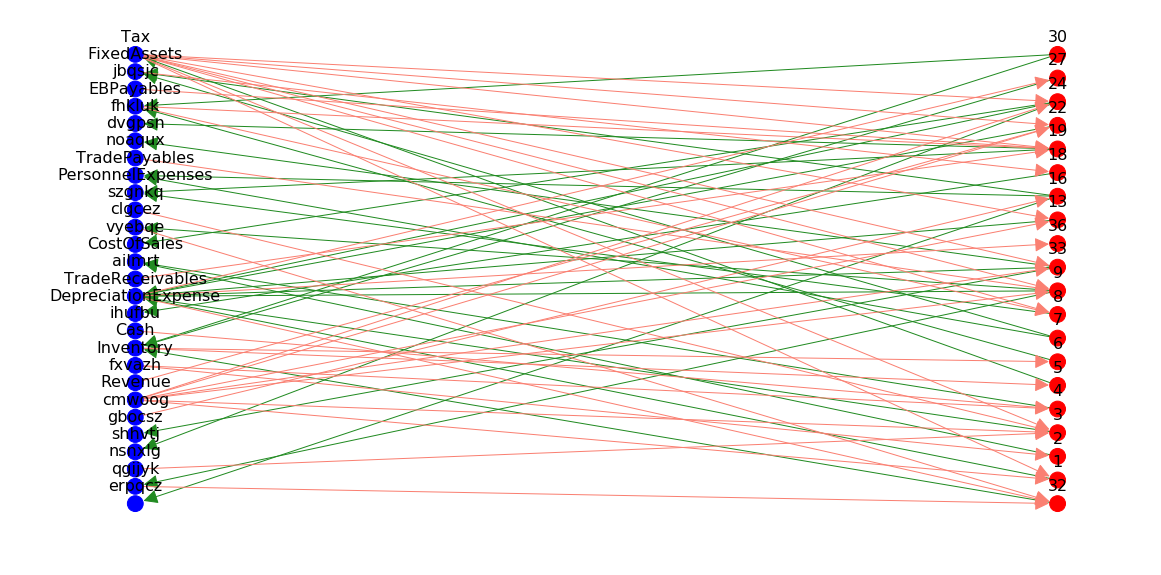

In [6]:
from NetEmbs.Vis.plots import plotFSN
plotFSN(fsn, edge_labels=False)

In [7]:
from NetEmbs.FSN.utils import add_similar, get_pairs
add_similar(d)

,ID,Signature,Name,FA_Name,Value,Debit,Credit,from,Similar_BP
0,1,"([('Revenue', 0.8261846226499184), ('Tax', 0.1...",Revenue_1,Revenue,-487.000000,0.000000,0.826185,True,"[(24, 108), (13, 96), (9, 91)]"
1,1,"([('Revenue', 0.8261846226499184), ('Tax', 0.1...",Tax_1,Tax,-102.456626,0.000000,0.173815,True,"[(24, 108), (13, 96), (9, 91)]"
2,1,"([('Revenue', 0.8261846226499184), ('Tax', 0.1...",TradeReceivables_1,TradeReceivables,589.456626,1.000000,0.000000,False,"[(24, 108), (13, 96), (9, 91)]"
3,2,"([('Inventory', 1.0)], [('CostOfSales', 1.0)])",CostOfSales_8,CostOfSales,487.000000,1.000000,0.000000,False,"[(4, 360)]"
4,2,"([('Inventory', 1.0)], [('CostOfSales', 1.0)])",Inventory_8,Inventory,-487.000000,0.000000,1.000000,True,"[(4, 360)]"
5,3,"([('Revenue', 0.819660287888384), ('Tax', 0.17...",Revenue_8,Revenue,-909.000000,0.000000,0.819660,True,"[(9, 120), (24, 103), (22, 98)]"
6,3,"([('Revenue', 0.819660287888384), ('Tax', 0.17...",Tax_8,Tax,-190.890000,0.000000,0.172129,True,"[(9, 120), (24, 103), (22, 98)]"
7,3,"([('Revenue', 0.819660287888384), ('Tax', 0.17...",nsnxlg_8,nsnxlg,-1.182302,0.000000,0.001066,True,"[(9, 120), (24, 103), (22, 98)]"
8,3,"([('Revenue', 0.819660287888384), ('Tax', 0.17...",szgnkq_8,szgnkq,-7.923722,0.000000,0.007145,True,"[(9, 120), (24, 103), (22, 98)]"
9,3,"([('Revenue', 0.819660287888384), ('Tax', 0.17...",TradeReceivables_8,TradeReceivables,1108.996024,1.000000,0.000000,False,"[(9, 120), (24, 103), (22, 98)]"


## Testing different Pairs construction

In [11]:
from NetEmbs.FSN import *
randomWalk(fsn, 1, length=100)

[1,
 22,
 13,
 9,
 22,
 9,
 22,
 9,
 13,
 24,
 22,
 1,
 22,
 13,
 22,
 13,
 8,
 19,
 8,
 19,
 9,
 13,
 24,
 22,
 1,
 3,
 1,
 3,
 13,
 1,
 22,
 13,
 24,
 3,
 24,
 1,
 22,
 24,
 1,
 9,
 1,
 9,
 22,
 3,
 1,
 22,
 1,
 24,
 9,
 3,
 13,
 22,
 3,
 24,
 1,
 9,
 13,
 22,
 1,
 22,
 24,
 22,
 24,
 19,
 8,
 19,
 8,
 19,
 8,
 1,
 22,
 24,
 22,
 13,
 3,
 13,
 9,
 24,
 1,
 13,
 3,
 13,
 3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3]

In [12]:
list(fsn.successors("TradeReceivables")), list(fsn.predecessors(3))

(['TradeReceivables'], ['Revenue', 'Tax', 'nsnxlg', 'szgnkq'])